In [1]:
from likelihood import discrete_loglikelihood
from SS_DM_Prior import SS_DM_dist_setup
from prior import discrete_logprior
import numpy as np
from scipy.special import logsumexp
from scipy import interpolate
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

# disc_prior = discrete_logprior(logfunction=lambda x, y, z, w: np.log(np.abs(y+x-w)*z), name='test',
#                                axes=(np.linspace(0,1,101), np.linspace(0,1,51),), axes_names=['energy', 'offset'],
#                                default_hyperparameter_values=(1,1), hyperparameter_names=['h1', 'h2'])

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# disc_prior

In [3]:
# plt.figure()
# plt.hist2d(*disc_prior.sample(100000), bins=(50,50))
# plt.show()

In [4]:
numsamples = int(1e4)
signalfraction = 0.5

nsig = int(signalfraction*numsamples)
nbkg = int((1-signalfraction)*numsamples)

# Prior Sampling

In [5]:
darkSUSY_to_Gammapy_converter = {
    "tt": "t",
    "W+W-": "W",
    "ZZ": "Z",
    "HH": "h",
}

darkSUSY_BFs_cleaned = pd.read_csv('BFCalc/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

darkSUSY_massvalues = darkSUSY_BFs_cleaned.iloc[:,1]/1e3

darkSUSY_lambdavalues = darkSUSY_BFs_cleaned.iloc[:,2]

channelfuncdictionary = {}

modulefolderpath = 'BFCalc'
log10xvals = np.load(modulefolderpath+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")
massvalues = np.load(modulefolderpath+f"/griddata/massvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in list(darkSUSY_to_Gammapy_converter.keys()):
    gammapychannel = darkSUSY_to_Gammapy_converter[darkSUSYchannel]
    
    tempspectragrid = np.load(modulefolderpath+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
    
    channelfuncdictionary[darkSUSYchannel] = interpolate.RegularGridInterpolator((np.log10(massvalues/1e3), log10xvals), np.array(tempspectragrid), 
                                                                                 method='linear', bounds_error=False, fill_value=1e-3000)



partial_sigmav_interpolator_dictionary = {channel: interpolate.LinearNDInterpolator((darkSUSY_massvalues, darkSUSY_lambdavalues),darkSUSY_BFs_cleaned.iloc[:,idx+3]) for idx, channel in enumerate(list(darkSUSY_to_Gammapy_converter.keys()))}



def nontrivial_coupling(logmass, logenergy, coupling=0.1, partial_sigmav_interpolator_dictionary=partial_sigmav_interpolator_dictionary, channelfuncdictionary=channelfuncdictionary ):
    
    
    logspectra = -np.inf
    for channel in channelfuncdictionary.keys():
        logspectra = np.logaddexp(logspectra, np.log(partial_sigmav_interpolator_dictionary[channel](10**logmass, coupling)*channelfuncdictionary[channel]((logmass, logenergy-logmass))))
    
    
    return logspectra
        

In [6]:
from utils3d import longitudeaxistrue, latitudeaxistrue, log10eaxistrue


logDMpriorfunc = SS_DM_dist_setup(nontrivial_coupling, longitudeaxistrue, latitudeaxistrue)

In [7]:
logenergy_true_logjacob = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]

In [8]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(1,), hyperparameter_names=['mass'], logjacob=logenergy_true_logjacob)
DM_prior

(1,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist_setup.<locals>.DM_signal_dist at 0x7fe8b340da60>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

In [9]:
sig_samples = DM_prior.sample(nsig)

In [10]:
sigpriorvalues = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (1.0,))+logenergy_true_logjacob, axis=(1,2)))

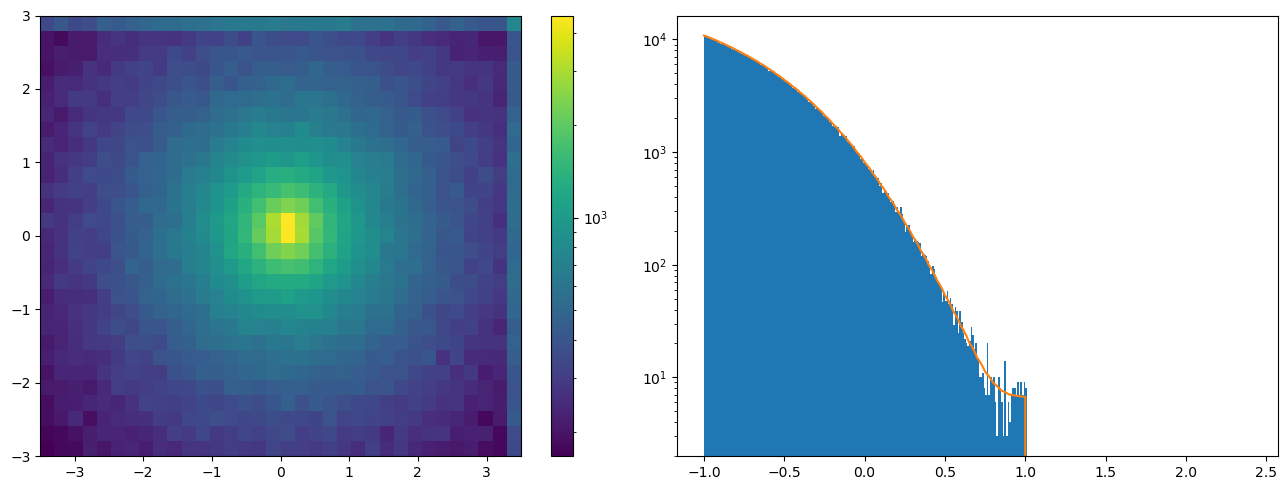

In [11]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist2d(sig_samples[1,:], sig_samples[2,:], bins=(longitudeaxistrue, latitudeaxistrue), norm=LogNorm())
plt.colorbar()

plt.subplot(1,2,2)
sigtruehistvals = plt.hist(sig_samples[0,:], bins=log10eaxistrue,)
plt.plot(log10eaxistrue, np.max(sigtruehistvals[0])*sigpriorvalues/np.max(sigpriorvalues))
plt.yscale('log')

plt.tight_layout()

In [12]:
astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")
from utils3d import bkgdist

nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'],)

In [13]:
bkg_prior((0.0,0.0,0.0))

3.3067634676689934

In [14]:
bkg_samples = bkg_prior.sample(nbkg)

bkg_samples

array([[-0.98      , -0.65      , -0.66      , ..., -0.81      ,
        -0.74      , -0.64      ],
       [ 0.        , -1.85294118,  0.        , ...,  1.02941176,
        -2.88235294,  2.05882353],
       [-0.31034483, -0.51724138,  3.        , ..., -2.37931034,
         1.55172414, -2.17241379]])

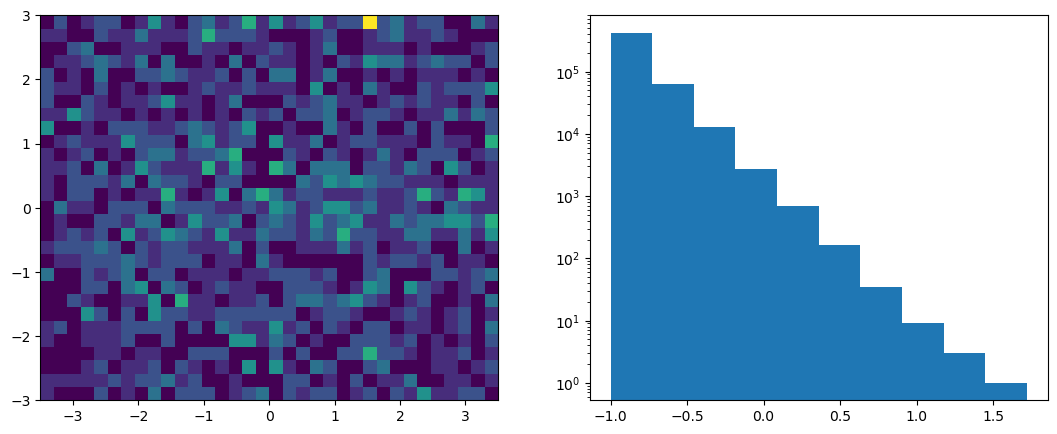

In [15]:
plt.figure(figsize=(13,5))
logenergycutoff = 0.0
plt.subplot(1,2,1)
plt.hist2d(bkg_samples[:,bkg_samples[0]>logenergycutoff][1,:],
           bkg_samples[:,bkg_samples[0]>logenergycutoff][2,:], 
           bins=[longitudeaxistrue, latitudeaxistrue])

plt.subplot(1,2,2)
plt.hist(bkg_samples[0,:])
plt.yscale('log')
plt.show()

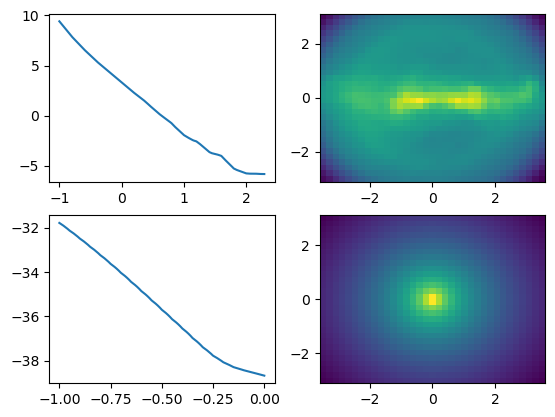

In [16]:

plt.figure()

plt.subplot(221)
plt.plot(log10eaxistrue, bkg_prior((log10eaxistrue,0.0,0.0)))
plt.subplot(222)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),))[160,:,:].T)

plt.subplot(223)
plt.plot(log10eaxistrue, logDMpriorfunc(log10eaxistrue,0.0,0.0, 0.0))
plt.subplot(224)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logDMpriorfunc(0.0,*np.meshgrid(longitudeaxistrue, latitudeaxistrue), 0.0))
plt.show()

In [17]:
bkg_samples[:,bkg_samples[0]>0]

array([[ 0.09      ,  0.45      ,  0.5       , ...,  0.67      ,
         0.09      ,  0.65      ],
       [-1.64705882,  1.64705882,  3.5       , ...,  0.        ,
        -2.67647059,  1.44117647],
       [-0.51724138,  1.75862069,  1.75862069, ..., -0.51724138,
         1.75862069,  2.79310345]])

In [18]:
bkg_samples[0].shape

(500000,)

In [19]:
100000000/1e8

1.0

# Likelihood Sampling

In [20]:
testfunc = lambda w, x, y, z: w*z+x*y
disc_like = discrete_loglikelihood(logfunction=testfunc, axes=[np.linspace(0,1,100),np.linspace(-1,1,100)], dependent_axes=[np.linspace(1,2,100),np.linspace(-1,1,100)])


beeeep
Number of data dimensions 2


In [21]:
testsamples = disc_like.sample((2.0,-1.0), int(1e5))

In [22]:
testsamples.shape

(2, 100000)

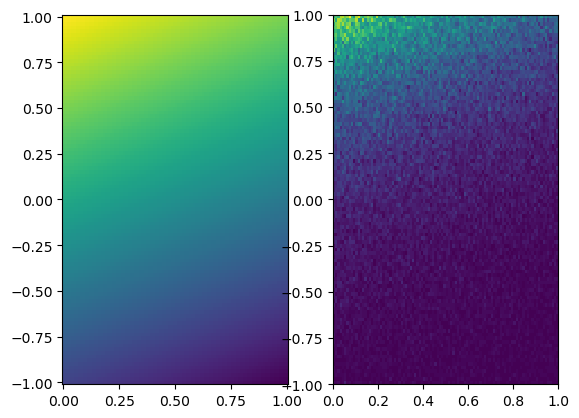

In [23]:
testaxis1, testaxis2 = np.linspace(0,1,100),np.linspace(-1,1,100)

plt.figure()
plt.subplot(121)
plt.pcolormesh(testaxis1, testaxis2, testfunc(*np.meshgrid(testaxis1, testaxis2), 2.0, -1.0,))

plt.subplot(122)
plt.hist2d(testsamples[0], testsamples[1], bins=[100, 100])
plt.show()

In [24]:
from utils3d import edisp_test, log10eaxis

edisp_like = discrete_loglikelihood(logfunction=edisp_test, 
                                    axes=log10eaxis, axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=[log10eaxistrue, longitudeaxistrue, latitudeaxistrue], logjacob=np.log(10**log10eaxis),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
edisp_like

beep


/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/likelihood.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.array(axes).ndim==1 and np.array(dependent_axes).ndim==1:
/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/numpy/lib/function_base.py:4360: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output = [np.asanyarray(x).reshape(s0[:i] + (-1,) + s0[i + 1:])


discrete log likelihood class
---------------------------------
name = energy dispersion
logfunction type is <function edisp_test at 0x7fe89144bee0>
input units of None
over axes log10E recon
with dependent axes ['log10E true', 'lon', 'lat']

In [25]:
sig_log10e_edisp_samples = np.array([edisp_like.sample(signal_event_tuple, 1) for signal_event_tuple in tqdm(sig_samples.T)])

  0%|          | 676/500000 [00:00<04:52, 1706.96it/s]/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/inverse_transform_sampling.py:8: RuntimeWarning: invalid value encountered in subtract
  logpmf = logpmf - logsumexp(logpmf)
  6%|▌         | 28820/500000 [00:17<04:56, 1589.09it/s]

KeyboardInterrupt: 

In [ ]:
signalpriorvals = np.exp(logsumexp(DM_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),), (1.0,)), axis=(1,2)))

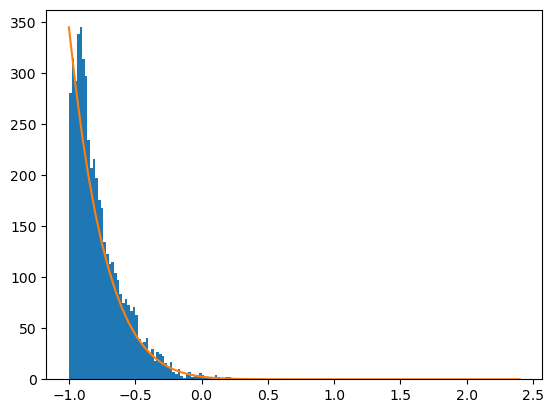

In [ ]:
plt.figure()
histvals = plt.hist(np.squeeze(sig_log10e_edisp_samples), bins=log10eaxis)
plt.plot(log10eaxistrue, np.max(histvals[0])*signalpriorvals/np.max(signalpriorvals))
plt.show()

In [ ]:
bkg_log10e_edisp_samples = np.array([edisp_like.sample(event_tuple, 1) for event_tuple in bkg_samples.T])

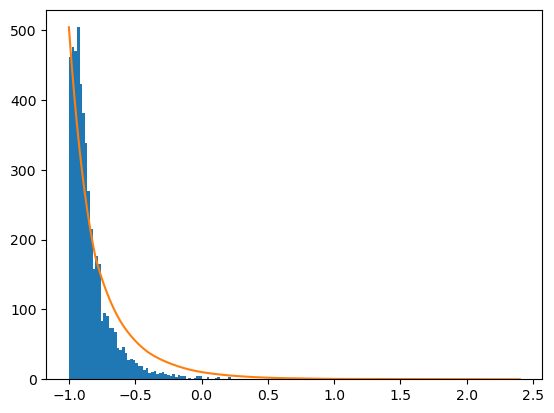

In [ ]:
bkgpriorvals = np.exp(logsumexp(bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),)).T+np.log(10**log10eaxistrue), axis=(0,1)))

plt.figure()
histvals = plt.hist(np.squeeze(bkg_log10e_edisp_samples), bins=log10eaxis)
plt.plot(log10eaxistrue, np.max(histvals[0])*bkgpriorvals/np.max(bkgpriorvals))
plt.show()